# Autoencoder

In this work we will build simple and more complicated autoencoders on the MNIST dataset.

An autoencoder is a neural network that is trained to attempt to copy its input to its output. It has two parts :


- An encoder function $h_{\theta_{e}} : \mathcal{X} \rightarrow \mathcal{Z}$ that pushes the inputs $x$ in a smaller dimensional space.
- A decoder function $g_{\theta_{d}} : \mathcal{Z} \rightarrow \mathcal{X}$ that reconstructs from the low dimensional space to the initial space

Very generally autoencoders aim at solving  : 

$$\underset{\theta_{e},\theta_{d}}{\text{min}} \ \underset{x \sim \mathbb{P}_{r}}{\mathbb{E}}[L(x,g_{\theta_{d}},h_{\theta_{e}})]$$

<img src="imgs/autoencoder.png" alt="Drawing" style="width: 500px;"/>



In [1]:
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from matplotlib import cm
def graph_colors(nx_graph):
    #cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["blue","red"])
    #cm1 = mcol.Colormap('viridis')

    cnorm = mcol.Normalize(vmin=0,vmax=9)
    cpick = cm.ScalarMappable(norm=cnorm,cmap='Set1')
    cpick.set_array([])
    val_map = {}
    for k,v in nx.get_node_attributes(nx_graph,'attr').items():
        #print(v)
        val_map[k]=cpick.to_rgba(v)
    #print(val_map)
    colors=[]
    for node in nx_graph.nodes():
        #print(node,val_map.get(str(node), 'black'))
        colors.append(val_map[node])
    return colors

Using TensorFlow backend.


Load the MNIST dataset using the following command:

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


##### 1 Write a function that builds a simple autoencoder 

The autoencoder must have a simple Dense layer with relu activation. The number of node of the dense layer is a parameter of the function.

The function must return the entire autoencoder model as well as the encoder and the decoder.
You will need the following classes:
- [Input](https://keras.io/layers/core/)
- [Dense](https://keras.io/layers/core/)
- [Model](https://keras.io/models/model/)

In [3]:
def build_simple_autoencoder(encoding_dim=32):
    input_img = Input(shape=(784,))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')   
    return autoencoder,encoder,decoder

##### 2. Build the autoencoder with a embedding size of 32 and print the number of parameters of the model. What do they relate to ?


In [4]:
autoencoder,encoder,decoder=build_simple_autoencoder(32)

In [5]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [6]:
2*784*32+784+32

50992

##### 3. Fit the autoencoder using 32 epochs with a batch size of 256

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.3664 - val_loss: 0.2713
Epoch 2/50
60000/60000 [==============================] - 3s 46us/step - loss: 0.2640 - val_loss: 0.2530
Epoch 3/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.2426 - val_loss: 0.2301
Epoch 4/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2223 - val_loss: 0.2120
Epoch 5/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.2070 - val_loss: 0.1992
Epoch 6/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.1957 - val_loss: 0.1893
Epoch 7/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.1869 - val_loss: 0.1815
Epoch 8/50
60000/60000 [==============================] - 3s 51us/step - loss: 0.1799 - val_loss: 0.1752
Epoch 9/50
60000/60000 [==============================] - 3s 47us/step - loss: 0.1741 - val_loss: 0.1700
Epoch

##### 4. Using the history module of the autoencoder write a function that plots the learning curves with respect to the epochs on the train and test set. What can you say about these learning curves ? Give also the last loss on the test set

In [8]:
def plot_learning_curves(autoencoder):
    history=autoencoder.history
    # summarize history for loss
    plt.figure(figsize=(7,7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

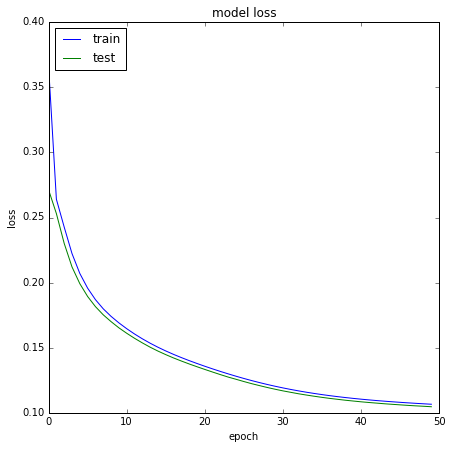

In [9]:
plot_learning_curves(autoencoder)

In [10]:
autoencoder.history.history['val_loss'][::-1][0]

0.10466250305175781

##### 5. Write a function that plots a fix number of example of the original images on the test as well as their reconstruction

In [11]:
def plot_reconstructed_images(encoder,decoder,x_test):
   # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(x_test)
    print('Mean encoded image : %.2f' %encoded_imgs.mean())
    decoded_imgs = decoder.predict(encoded_imgs)
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Mean encoded image : 7.15


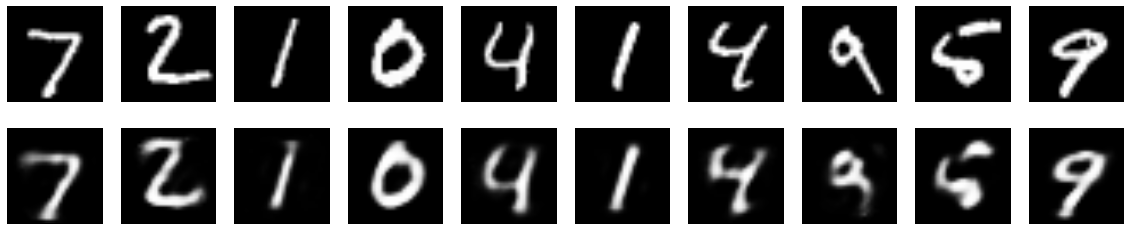

In [12]:
plot_reconstructed_images(encoder,decoder,x_test)

### Nearest neighbours graphs
The goal of this part is to visualize the neighbours graph in the embedding. It corresponds the the graph of the k-nearest neighbours using the euclidean distance of points the element in the embedding

The function that computes the neighbors graphs can be found here 

In [13]:
from sklearn.neighbors import kneighbors_graph
import networkx as nx

In [14]:
def plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3): #to explain
    X=encoder.predict(x_test[1:ntest])
    y=y_test[1:ntest]
    A = kneighbors_graph(X, p, mode='connectivity', include_self=True)
    G=nx.from_numpy_array(A.toarray())
    nx.set_node_attributes(G,dict(zip(range(ntest),y)),'attr')
    fig, ax = plt.subplots(figsize=(10,10))
    pos=nx.layout.kamada_kawai_layout(G)
    nx.draw(G,pos=pos
            ,with_labels=True
            ,labels=nx.get_node_attributes(G,'attr')
            ,node_color=graph_colors(G))
    plt.tight_layout()
    plt.title('Nearest Neighbours Graph',fontsize=15)
    plt.show()

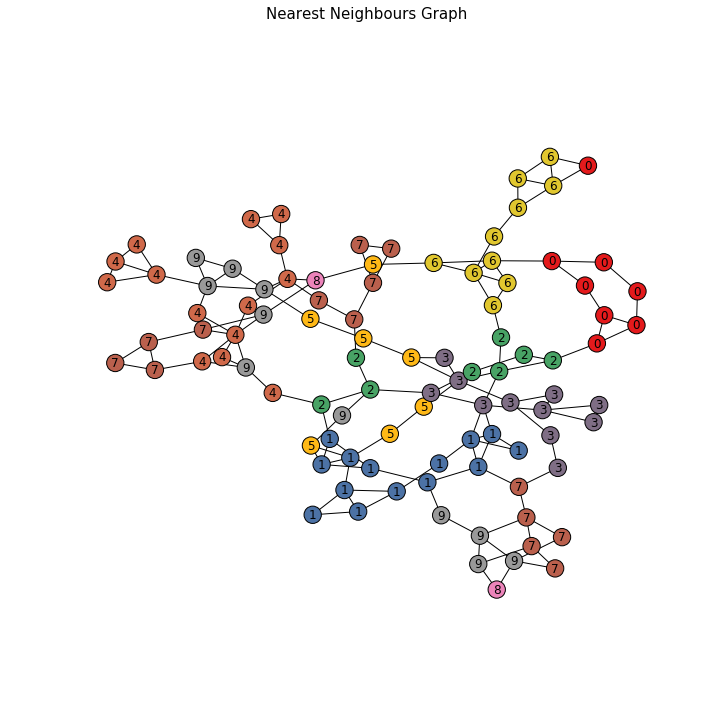

In [15]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

We can also plot a 2D MDS of the embedding space: 

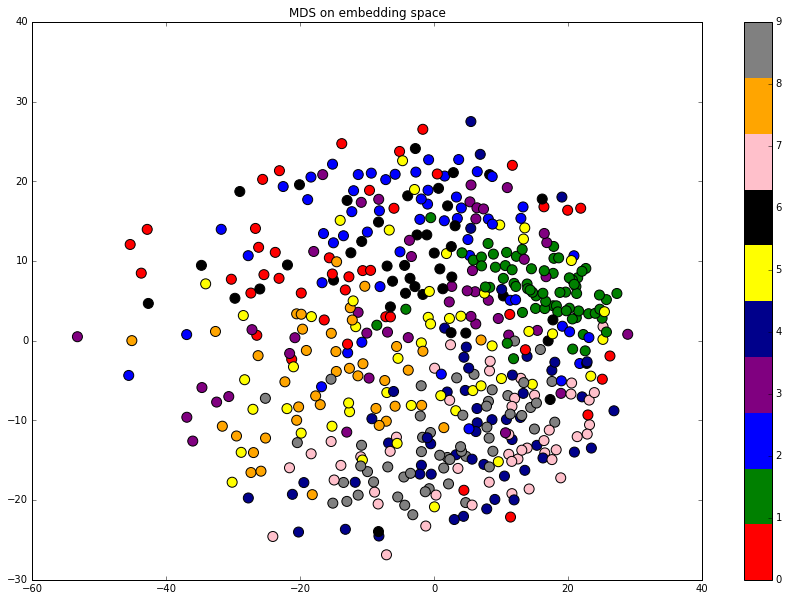

In [18]:
from sklearn.manifold import MDS
import matplotlib

ntest=500
mds=MDS(n_components=2)
X=encoder.predict(x_test[1:ntest])
X_dim2=mds.fit_transform(X)
colors = ['red','green','blue','purple','darkblue','yellow','black','pink','orange','grey']
label=y_test[1:ntest]
plt.figure(figsize=(15,10))
plt.scatter(X_dim2[:,0]
            ,X_dim2[:,1]
            ,c=label,cmap=matplotlib.colors.ListedColormap(colors)
           ,s=100)
plt.colorbar()
plt.title('MDS on embedding space')
plt.show()

### Reduce the dimension of the embedding

##### 6. Rerun the previous example using an embedding dimension of 16

In [19]:
autoencoder,encoder,decoder=build_simple_autoencoder(16)

In [20]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               13328     
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0
_________________________________________________________________


In [21]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.3772 - val_loss: 0.2738
Epoch 2/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2695 - val_loss: 0.2629
Epoch 3/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2546 - val_loss: 0.2425
Epoch 4/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.2338 - val_loss: 0.2233
Epoch 5/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.2184 - val_loss: 0.2109
Epoch 6/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.2079 - val_loss: 0.2020
Epoch 7/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.2001 - val_loss: 0.1951
Epoch 8/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.1937 - val_loss: 0.1895
Epoch 9/50
60000/60000 [==============================] - 3s 56us/step - loss: 0.1885 - val_loss: 0.1847
Epoch

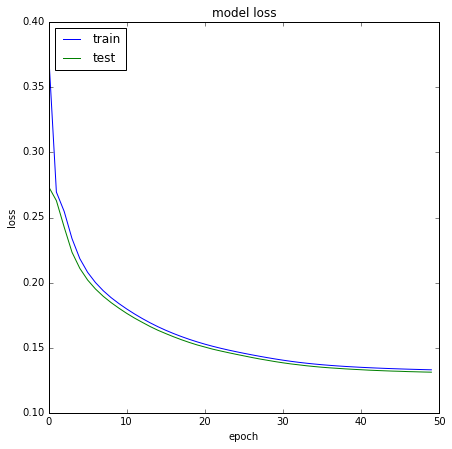

In [22]:
plot_learning_curves(autoencoder)

In [23]:
autoencoder.history.history['val_loss'][::-1][0]

0.13119826769828796

Mean encoded image : 10.03


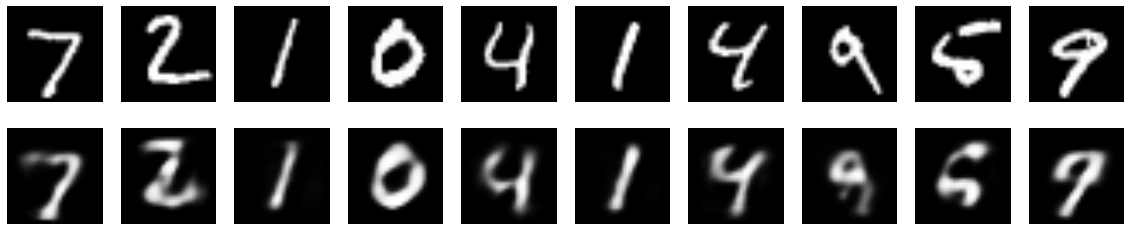

In [24]:
plot_reconstructed_images(encoder,decoder,x_test)

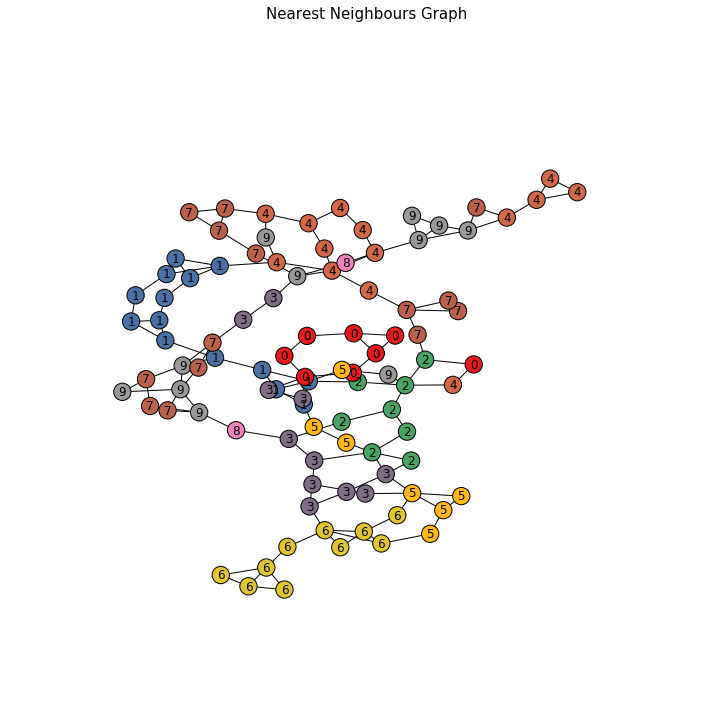

In [25]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

## Adding sparsity


##### Question 7.  Add sparisity over the weights

In this part we will add sparisity over the weights on the embedding layer. Write a function that build such a autoencoder (using a l1 regularization with a configurable regularization parameter and using the same autoencoder architecture that before)

You will use the [regularizers](https://keras.io/regularizers/) module.

In [26]:
from keras import regularizers

In [27]:
def build_regularized_autoencoder(encoding_dim=32,regul=10e-5):
    
    # this is the size of our encoded representations
    encoding_dim = encoding_dim  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

    # this is our input placeholder
    input_img = Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(regul))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(784, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder,encoder,decoder

In [28]:
autoencoder,encoder,decoder=build_regularized_autoencoder()

In [29]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 63us/step - loss: 0.6731 - val_loss: 0.6485
Epoch 2/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/50
60000/60000 [==============================] - 3s 49us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/50
60000/60000 [==============================] - 4s 64us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/50
60000/60000 [==============================] - 4s 60us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/50
60000/60000 [==============================] - 3s 58us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/50
60000/60000 [==============================] - 4s 59us/step - loss: 0.4531 - val_loss: 0.4457
Epoch

In [ ]:
plot_learning_curves(autoencoder)

In [ ]:
autoencoder.history.history['val_loss'][::-1][0]

In [ ]:
plot_reconstructed_images(encoder,decoder,x_test)

In [ ]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

The regularization is too strong

In [ ]:
autoencoder,encoder,decoder=build_regularized_autoencoder(regul=10e-7)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
plot_reconstructed_images(encoder,decoder,x_test)

The mean of the encoded image is less than before -> due to the sparsity

# Deep autoencoder

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

##### Question 8. Use the following deep autoencoder to rerun the previous example. What can you say about the quality of the autoencoding ?

In [ ]:
def build_deep_autoencoder(encoding_dim=32):
    

    input_img = Input(shape=(784,))
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu', name="embedding_layer")(encoded)

    encoder=Model(input_img, encoded)

    
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    
    autoencoder = Model(input_img, decoded)
    

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder,encoder

In [ ]:
autoencoder,encoder=build_deep_autoencoder()

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
plot_learning_curves(autoencoder)

In [ ]:
autoencoder.history.history['val_loss'][::-1][0]

In [ ]:
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

# Convolutionnal autoencoder

# Application to denoising